In [1]:
import sys
sys.path.append('/home/enric/repositorios/tiny_diffusion')

import torch
from tqdm import tqdm
from model.dit_utils import build_dataloader, load_encoders
from model.mmdit import MMDiT
from model.rectified_flow import RectifiedFlow
from diffusers.image_processor import VaeImageProcessor
from data.prepare_data import encode_prompt_with_t5

torch._inductor.config.coordinate_descent_tuning = True
torch._inductor.config.triton.unique_kernel_names = True
torch._inductor.config.fx_graph_cache = True

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

import os
os.environ["TORCH_COMPILE_THREADS"] = "1"

device = 'cuda'

/home/enric/repositorios/tiny_diffusion/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
prompts = [
    'The image shows a painting of a tall ship in the water, with its sails billowing in the wind. The ship is surrounded by a vast expanse of blue water, and the sky is a deep blue with a few white clouds. The sun is shining brightly, reflecting off the surface of the water and creating a beautiful contrast between the dark blue of the ship and the bright white of the sky.',
    'The image shows the ruins of an old building in the middle of a field, surrounded by grass, plants, and trees. The sky is visible in the background, and the building appears to be in a state of disrepair, with crumbling walls and broken windows.',
    'The image shows a seagull perched atop a cement pillar in front of the Colosseum in Rome, Italy. The sky is filled with clouds and the buildings of the city can be seen in the background.',
    'The image shows a painting of a river with a house in the background, surrounded by trees, plants, and flowers. The sky is filled with clouds, creating a peaceful atmosphere.',
    'The image shows a small house nestled in the middle of a grassy field surrounded by trees and rocks, with a mountain in the background and clouds in the sky.',
    'The image shows an old black and white photo of a man and woman standing next to each other. The man is wearing a cap and has a cigarette in his mouth, while the woman is wearing spectacles. In the background, there is a wall.',
    'The image shows an old black and white photo of a young boy standing on a bench with a wall in the background. He is wearing a dress and footwear, giving the photo a classic and timeless feel.',
    'The image shows a brown and cream colored frog sitting on top of a green leaf with a blurred background.',
    'The image shows two men walking down a street lined with trees. They are both wearing coats and hats, and one of them is holding a bag. In the background, there is a building with windows, railings, and balconies, and the sky is visible above them.',
    'The image shows a close up of a tree branch with green leaves against a blurred background. The leaves are a vibrant green color, and the background is slightly out of focus, giving the image a dreamy feel.'
]

In [3]:
device = 'cuda'

vae_model, tokenizer, text_encoder = load_encoders(
    vae_path="black-forest-labs/FLUX.1-dev",
    text_encoder_path="EleutherAI/pile-t5-large",
    device=device,
    compile_models=True,
)

In [4]:
torch.cuda.empty_cache()
diffusion_model = RectifiedFlow(
    MMDiT (
        in_channels=16,
        patch_size=2,
        depth=16,
        hidden_size=768,
        mlp_ratio=4,
        num_heads=12,
        context_input_size=1024,
    ),
    learn_sigma=False
)
diffusion_model.model.load_state_dict(torch.load('/mnt/d/tiny_diffusion/checkpoints/run_20241111_194209/130000.pt', weights_only=False))
diffusion_model.model = diffusion_model.model.to(device)
diffusion_model.model = diffusion_model.model.eval()


In [5]:
def generate_image(
    prompt: str,
    neg_prompt: str = None,
    seed: int = 12,
    cfg: float = 4.,
    num_steps: int = 50
):
    if seed is not None:
        generator = torch.Generator(device=device).manual_seed(seed)
    else:
        generator = None
        
    in_channels, latent_size = 16, 32
    conds = encode_prompt_with_t5(
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        prompt=[prompt],
        device=device,
        max_sequence_length=128
    )
    if neg_prompt:
        null_cond= encode_prompt_with_t5(
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            prompt=[""],
            device=device,
            max_sequence_length=128
        )
    else:
        null_cond = None
    init_noise = torch.randn(
        size=(1, in_channels, latent_size, latent_size),
        device=device, dtype=torch.bfloat16, generator=generator
    ) 
    with torch.amp.autocast(device_type=device):
        images = diffusion_model.sample_with_xps(
            init_noise, conds, null_cond=null_cond, sample_steps=num_steps, cfg=cfg
        )

    imgs_decoded = [
        VaeImageProcessor().postprocess(
            image=vae_model.decode((img.to(torch.float32) / vae_model.config.scaling_factor) + vae_model.config.shift_factor).sample, 
            do_denormalize=[True, True]
        )[0]
        for img in images
    ]
    return imgs_decoded

# Inference of reference prompts

In [6]:
prompts = [
    'The image shows a painting of a tall ship in the water, with its sails billowing in the wind. The ship is surrounded by a vast expanse of blue water, and the sky is a deep blue with a few white clouds. The sun is shining brightly, reflecting off the surface of the water and creating a beautiful contrast between the dark blue of the ship and the bright white of the sky.',
    'The image shows the ruins of an old building in the middle of a field, surrounded by grass, plants, and trees. The sky is visible in the background, and the building appears to be in a state of disrepair, with crumbling walls and broken windows.',
    'The image shows a seagull perched atop a cement pillar in front of the Colosseum in Rome, Italy. The sky is filled with clouds and the buildings of the city can be seen in the background.',
    'The image shows a painting of a river with a house in the background, surrounded by trees, plants, and flowers. The sky is filled with clouds, creating a peaceful atmosphere.',
    'The image shows a small house nestled in the middle of a grassy field surrounded by trees and rocks, with a mountain in the background and clouds in the sky.',
    'The image shows an old black and white photo of a man and woman standing next to each other. The man is wearing a cap and has a cigarette in his mouth, while the woman is wearing spectacles. In the background, there is a wall.',
    'The image shows an old black and white photo of a young boy standing on a bench with a wall in the background. He is wearing a dress and footwear, giving the photo a classic and timeless feel.',
    'The image shows a brown and cream colored frog sitting on top of a green leaf with a blurred background.',
    'The image shows two men walking down a street lined with trees. They are both wearing coats and hats, and one of them is holding a bag. In the background, there is a building with windows, railings, and balconies, and the sky is visible above them.',
    'The image shows a close up of a tree branch with green leaves against a blurred background. The leaves are a vibrant green color, and the background is slightly out of focus, giving the image a dreamy feel.'
]

The image shows a painting of a tall ship in the water, with its sails billowing in the wind. The ship is surrounded by a vast expanse of blue water, and the sky is a deep blue with a few white clouds. The sun is shining brightly, reflecting off the surface of the water and creating a beautiful contrast between the dark blue of the ship and the bright white of the sky.


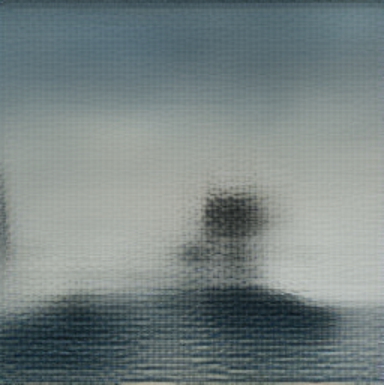

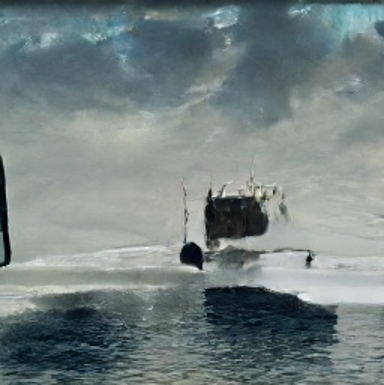

The image shows the ruins of an old building in the middle of a field, surrounded by grass, plants, and trees. The sky is visible in the background, and the building appears to be in a state of disrepair, with crumbling walls and broken windows.


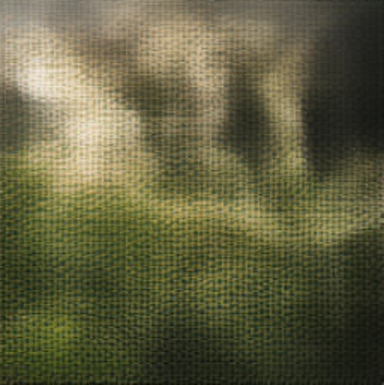

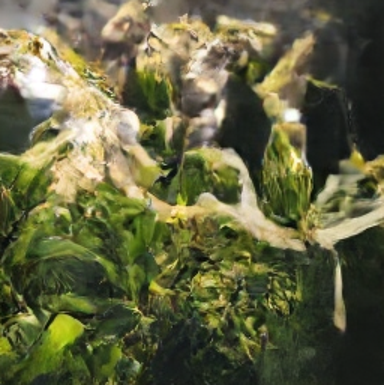

The image shows a seagull perched atop a cement pillar in front of the Colosseum in Rome, Italy. The sky is filled with clouds and the buildings of the city can be seen in the background.


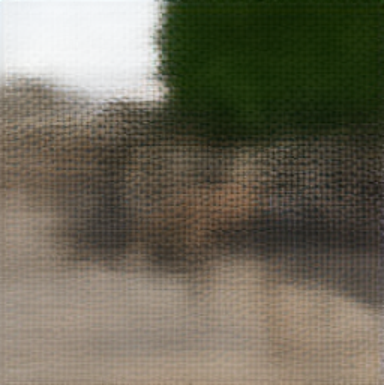

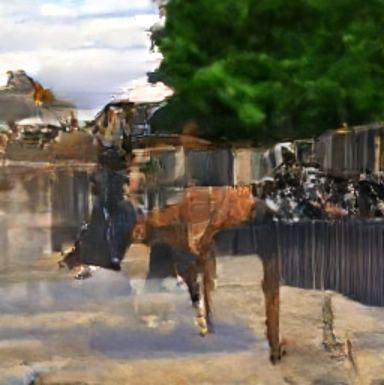

The image shows a painting of a river with a house in the background, surrounded by trees, plants, and flowers. The sky is filled with clouds, creating a peaceful atmosphere.


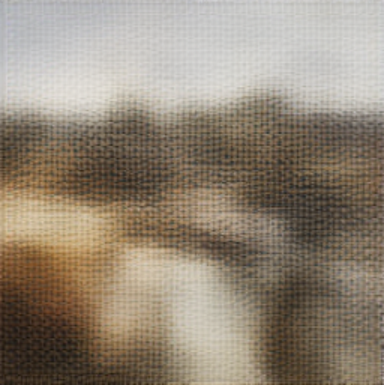

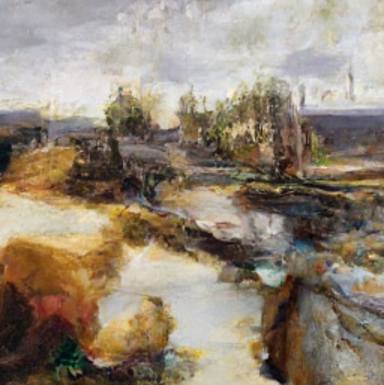

The image shows a small house nestled in the middle of a grassy field surrounded by trees and rocks, with a mountain in the background and clouds in the sky.


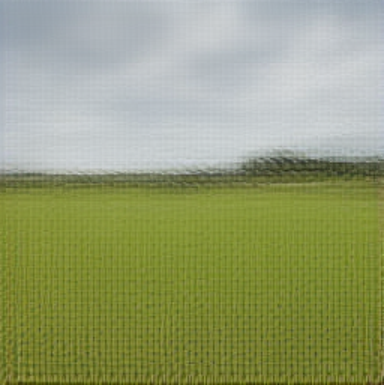

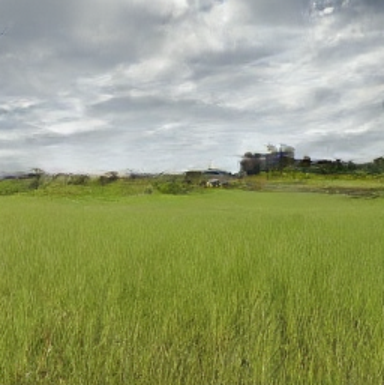

The image shows an old black and white photo of a man and woman standing next to each other. The man is wearing a cap and has a cigarette in his mouth, while the woman is wearing spectacles. In the background, there is a wall.


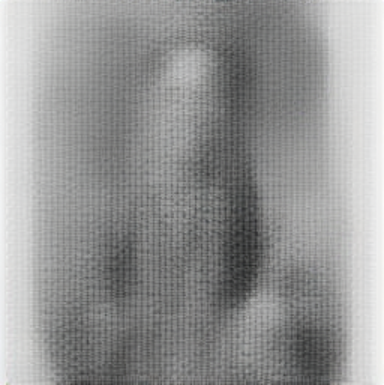

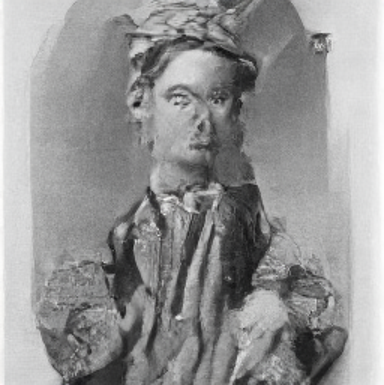

The image shows an old black and white photo of a young boy standing on a bench with a wall in the background. He is wearing a dress and footwear, giving the photo a classic and timeless feel.


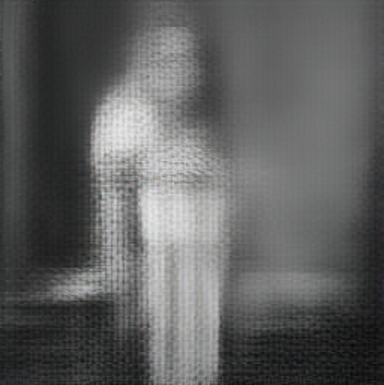

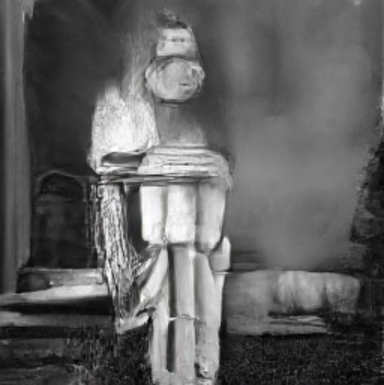

The image shows a brown and cream colored frog sitting on top of a green leaf with a blurred background.


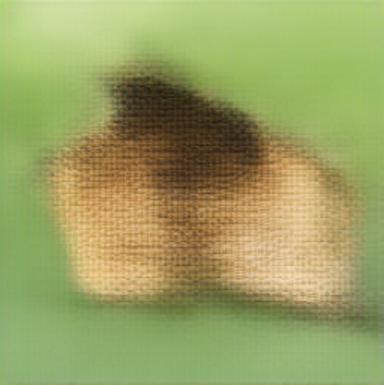

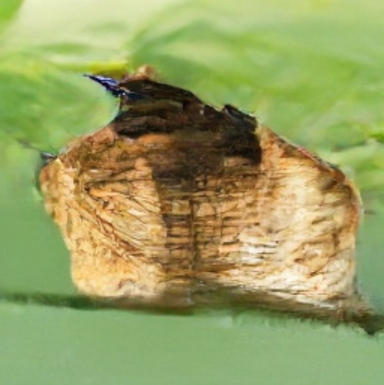

The image shows two men walking down a street lined with trees. They are both wearing coats and hats, and one of them is holding a bag. In the background, there is a building with windows, railings, and balconies, and the sky is visible above them.


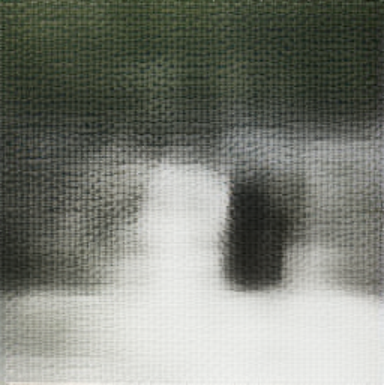

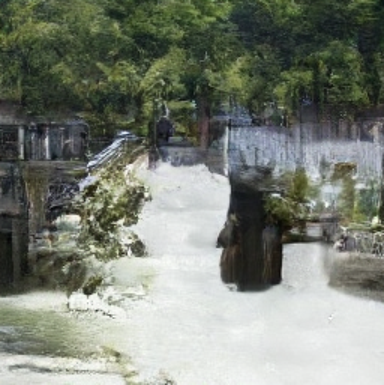

The image shows a close up of a tree branch with green leaves against a blurred background. The leaves are a vibrant green color, and the background is slightly out of focus, giving the image a dreamy feel.


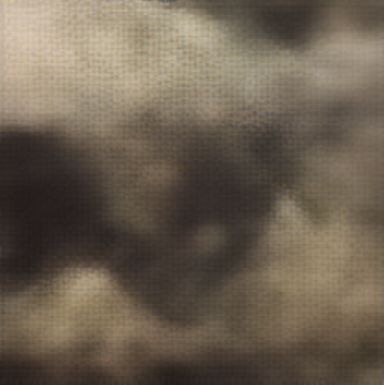

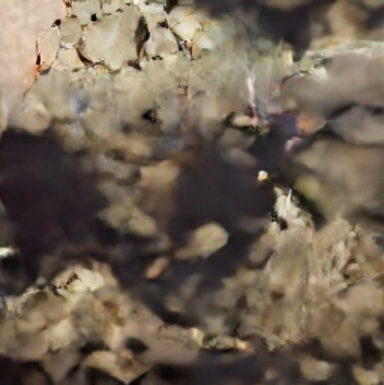

In [19]:
SIZE_R = (384, 384)
for prompt in prompts:
    imgs = generate_image(
        prompt=prompt,
        neg_prompt=None,
        seed=None,
        cfg=4.,
        num_steps=50
    )
    print(prompt)
    display(imgs[10].resize(SIZE_R))
    display(imgs[-1].resize(SIZE_R))
    print('==='*50)